<a href="https://colab.research.google.com/github/SageSquash/MTechImageEnhancement/blob/master/FINAL_MCLAHETF2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [139]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

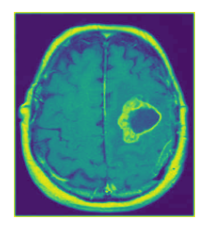

In [140]:
# Load and show image with bad contrast
img = plt.imread('/content/download (1).png')
from google.colab.patches import cv2_imshow
plt.imshow(img)
plt.axis('off')
plt.show()
# cv2_imshow(img)

In [141]:
img[..., 0] .shape

(231, 207)

In [142]:
import cv2
import numpy as np

# Read an image
image = img

# Print the original data type
print("Original data type: ", image.dtype)

# Convert the image to float32 data type
img = image.astype(np.float64)

# Print the new data type
print("New data type: ", img.dtype)

Original data type:  float32
New data type:  float64


In [143]:
# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()

In [144]:
import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.python.ops import gen_math_ops


def tf_batch_gather(params, indices, axis, name=None):
    """
    Extension of the batch_gather function in tensorflow
    (see https://github.com/tensorflow/tensorflow/blob/r1.13/tensorflow/python/ops/array_ops.py
    or https://www.tensorflow.org/api_docs/python/tf/batch_gather)
    Gather slices from `params` according to `indices` with leading batch dims.
    This operation assumes that the leading dimensions of `indices` are dense,
    and the gathers on the axis corresponding to the last dimension of `indices`.
    More concretely it computes:
    `result[i1, ..., in, j1, ..., jm, k1, ...., kl] = params[i1, ..., in, indices[i1, ..., in, j1, ..., jm], k1, ..., kl]`
    Therefore `params` should be a Tensor of shape [A1, ..., AN, C0, B1, ..., BM],
    `indices` should be a Tensor of shape [A1, ..., AN, C1, ..., CK] and `result` will be
    a Tensor of size `[A1, ..., AN, C1, ..., CK, B1, ..., BM]`.
    In the case in which indices is a 1D tensor, this operation is equivalent to
    `tf.gather`.
    See also `tf.gather` and `tf.gather_nd`.
    Args:
      params: A `Tensor`. The tensor from which to gather values.
      indices: A `Tensor`. Must be one of the following types: int32, int64. Index
          tensor. Must be in range `[0, params.shape[axis]`, where `axis` is the
          last dimension of `indices` itself.
      axis: A `Tensor`. Must be one of the following types: int32, int64. The axis
            in `params` to gather `indices` from.
      name: A name for the operation (optional).
    Returns:
      A Tensor. Has the same type as `params`.
    Raises:
      ValueError: if `indices` has an unknown shape.
    """

    with ops.name_scope(name):
        indices = ops.convert_to_tensor(indices, name="indices")
        params = ops.convert_to_tensor(params, name="params")
        indices_shape = tf.shape(indices)
        params_shape = tf.shape(params)

        ndims = indices.shape.ndims
        if ndims is None:
            raise ValueError("batch_gather does not allow indices with unknown "
                             "shape.")
        batch_indices = indices
        indices_dtype = indices.dtype.base_dtype
        accum_dim_value = tf.ones((), dtype=indices_dtype)
        # Use correct type for offset index computation
        casted_params_shape = gen_math_ops.cast(params_shape, indices_dtype)
        for dim in range(axis, 0, -1):
            dim_value = casted_params_shape[dim - 1]
            accum_dim_value *= casted_params_shape[dim]
            start = tf.zeros((), dtype=indices_dtype)
            step = tf.ones((), dtype=indices_dtype)
            dim_indices = gen_math_ops._range(start, dim_value, step)
            dim_indices *= accum_dim_value
            dim_shape = tf.stack([1] * (dim - 1) + [dim_value] + [1] * (ndims - dim),
                                 axis=0)
            batch_indices += tf.reshape(dim_indices, dim_shape)

        flat_inner_shape_indices = gen_math_ops.prod(indices_shape[:(axis + 1)], [0], False)
        flat_indices = tf.reshape(batch_indices, tf.concat([[flat_inner_shape_indices],
                                                            indices_shape[(axis + 1):]], axis=0))
        outer_shape = params_shape[(axis + 1):]
        flat_inner_shape_params = gen_math_ops.prod(params_shape[:(axis + 1)], [0], False)

        flat_params = tf.reshape(params, tf.concat([[flat_inner_shape_params], outer_shape], axis=0))
        flat_result = tf.gather(flat_params, flat_indices)
        result = tf.reshape(flat_result, tf.concat([indices_shape, outer_shape], axis=0))
        final_shape = indices.get_shape()[:axis].merge_with(
                params.get_shape()[:axis])
        final_shape = final_shape.concatenate(indices.get_shape()[axis:])
        final_shape = final_shape.concatenate(params.get_shape()[(axis + 1):])
        result.set_shape(final_shape)
        return result


def tf_batch_histogram(values, value_range, axis, nbins=100, dtype=tf.int32, use_map=True):
    """
    Computes histogram with fixed width considering batch dimensions
    :param values: Numeric `Tensor` containing the values for histogram computation.
    :param value_range: Shape [2] `Tensor` of same `dtype` as `values`. values <= value_range[0] will be mapped to
    hist[0], values >= value_range[1] will be mapped to hist[-1].
    :param axis: Number of batch dimensions. First axis to apply histogram computation to.
    :param nbins: Scalar `int32 Tensor`. Number of histogram bins.
    :param dtype: dtype for returned histogram, can be either tf.int32 or tf.int64.
    :return: histogram with batch dimensions.
    """

    # Get shape
    values_shape = tf.shape(values)
    batch_dim = values_shape[:axis]
    rest_dim = values_shape[axis:]
    num_batch = tf.reduce_prod(batch_dim)

    if use_map:
        values_reshaped = tf.reshape(values, tf.concat([[num_batch], rest_dim], 0))
        hist = tf.map_fn(lambda x: tf.histogram_fixed_width(x, value_range, nbins=nbins, dtype=dtype), values_reshaped,
                         dtype=dtype, parallel_iterations=64)
    else:
        # Normalize
        values_float = tf.cast(values, tf.float32)
        value_range_float = tf.cast(value_range, tf.float32)

        # Clip values
        values_norm = (values_float - value_range_float[0]) / (value_range_float[1] - value_range_float[0])
        values_clip1 = tf.maximum(values_norm, 0.5 / tf.cast(nbins, tf.float32))
        values_clip2 = tf.minimum(values_clip1, 1.0 - 0.5 / tf.cast(nbins, tf.float32))

        # Shift values
        values_shift = values_clip2 + tf.reshape(tf.range(tf.cast(num_batch, tf.float32), dtype=tf.float32),
                                                 tf.concat([batch_dim, tf.ones(tf.size(rest_dim), tf.int32)], 0))

        # Get histogram
        hist = tf.histogram_fixed_width(values_shift, [0., tf.cast(num_batch, tf.float32)], nbins=num_batch * nbins,
                                        dtype=dtype)

    return tf.reshape(hist, tf.concat([batch_dim, [nbins]], 0))

In [145]:
import numpy as np
import tensorflow as tf
# from .utils import *
tf.compat.v1.disable_eager_execution()

from itertools import product

def mclahe(x, kernel_size=None, n_bins=128, clip_limit=0.01, adaptive_hist_range=False, use_gpu=True):
    """
    Contrast limited adaptive histogram equalization implemented in tensorflow
    :param x: numpy array to which clahe is applied
    :param kernel_size: tuple of kernel sizes, 1/8 of dimension lengths of x if None
    :param n_bins: number of bins to be used in the histogram
    :param clip_limit: relative intensity limit to be ignored in the histogram equalization
    :param adaptive_hist_range: flag, if true individual range for histogram computation of each block is used
    :param use_gpu: Flag, if true gpu is used for computations if available
    :return: numpy array to which clahe was applied, scaled on interval [0, 1]
    """

    if kernel_size is None:
        kernel_size = tuple(s // 8 for s in x.shape)
    kernel_size = np.array(kernel_size)

    assert len(kernel_size) == len(x.shape)

    dim = len(x.shape)

    # Normalize data
    x_min = np.min(x)
    x_max = np.max(x)
    x = (x - x_min) / (x_max - x_min)

    # Pad data
    x_shape = np.array(x.shape)
    padding_x_length = kernel_size - 1 - ((x_shape - 1) % kernel_size)
    padding_x = np.column_stack(((padding_x_length + 1) // 2, padding_x_length // 2))
    padding_hist = np.column_stack((kernel_size // 2, (kernel_size + 1) // 2)) + padding_x
    x_hist_padded = np.pad(x, padding_hist, 'symmetric')

    # Set up tf graph
    with tf.compat.v1.variable_scope("clahe") as scope:
        tf_x_hist_padded_init = tf.compat.v1.placeholder(tf.float32, shape=x_hist_padded.shape)
        tf_x_hist_padded = tf.Variable(tf_x_hist_padded_init)
        tf_x_padded = tf.slice(tf_x_hist_padded, kernel_size // 2, x_shape + padding_x_length)

        # Form blocks used for interpolation
        n_blocks = np.ceil(np.array(x.shape) / kernel_size).astype(np.int32)
        new_shape = np.reshape(np.column_stack((n_blocks, kernel_size)), (2 * dim,))
        perm = tuple(2 * i for i in range(dim)) + tuple(2 * i + 1 for i in range(dim))
        tf_x_block = tf.transpose(tf.reshape(tf_x_padded, new_shape), perm=perm)
        shape_x_block = np.concatenate((n_blocks, kernel_size))

        # Form block used for histogram
        n_blocks_hist = n_blocks + np.ones(dim, dtype=np.int32)
        new_shape = np.reshape(np.column_stack((n_blocks_hist, kernel_size)), (2 * dim,))
        perm = tuple(2 * i for i in range(dim)) + tuple(2 * i + 1 for i in range(dim))
        tf_x_hist = tf.transpose(tf.reshape(tf_x_hist_padded, new_shape), perm=perm)

        # Get maps
        # Get histogram
        if adaptive_hist_range:
            hist_ex_shape = np.concatenate((n_blocks_hist, [1] * dim))
            tf_x_hist_ex_init = tf.compat.v1.placeholder(tf.float32, shape=n_blocks_hist)
            tf_x_hist_min = tf.Variable(tf_x_hist_ex_init, dtype=tf.float32)
            tf_x_hist_max = tf.reduce_max(tf_x_hist, np.arange(-dim, 0))
            tf_x_hist_norm = tf.Variable(tf_x_hist_ex_init, dtype=tf.float32)
            tf_get_hist_min = tf.compat.v1.assign(tf_x_hist_min, tf.reduce_min(tf_x_hist, np.arange(-dim, 0)))
            tf_get_hist_norm = tf.compat.v1.assign(tf_x_hist_norm, tf.where(tf.equal(tf_x_hist_min, tf_x_hist_max),
                                                                  tf.ones_like(tf_x_hist_min),
                                                                  tf_x_hist_max - tf_x_hist_min))

            tf_x_hist_scaled = (tf_x_hist - tf.reshape(tf_x_hist_min, hist_ex_shape))\
                               / tf.reshape(tf_x_hist_norm, hist_ex_shape)
        else:
            tf_x_hist_scaled = tf_x_hist
        tf_hist = tf.cast(tf_batch_histogram(tf_x_hist_scaled, [0., 1.], dim, nbins=n_bins), tf.float32)
        # Clip histogram
        tf_n_to_high = tf.reduce_sum(tf.nn.relu(tf_hist - np.prod(kernel_size) * clip_limit), -1, keepdims=True)
        tf_hist_clipped = tf.minimum(tf_hist, np.prod(kernel_size) * clip_limit) + tf_n_to_high / n_bins
        tf_cdf = tf.cumsum(tf_hist_clipped, -1)
        tf_cdf_slice_size = tf.constant(np.concatenate((n_blocks_hist, [1])), tf.int32)
        tf_cdf_min = tf.slice(tf_cdf, tf.constant([0] * (dim + 1), dtype=tf.int32), tf_cdf_slice_size)
        tf_cdf_max = tf.slice(tf_cdf, tf.constant([0] * dim + [n_bins - 1], dtype=tf.int32), tf_cdf_slice_size)
        tf_cdf_norm = tf.where(tf.equal(tf_cdf_min, tf_cdf_max), tf.ones_like(tf_cdf_max), tf_cdf_max - tf_cdf_min)
        tf_mapping = (tf_cdf - tf_cdf_min) / tf_cdf_norm

        map_shape = np.concatenate((n_blocks_hist, [n_bins]))
        tf_map_init = tf.compat.v1.placeholder(tf.float32, shape=map_shape)
        tf_map = tf.Variable(tf_map_init, dtype=tf.float32)
        tf_get_map = tf.compat.v1.assign(tf_map, tf_mapping)

        # Prepare initializer
        tf_x_block_init = tf.compat.v1.placeholder(tf.float32, shape=shape_x_block)

        # Set up slice of data and map
        tf_slice_begin = tf.compat.v1.placeholder(tf.int32, shape=(dim,))
        tf_map_slice_begin = tf.concat([tf_slice_begin, [0]], 0)
        tf_map_slice_size = tf.constant(np.concatenate((n_blocks, [n_bins])), dtype=tf.int32)
        tf_map_slice = tf.slice(tf_map, tf_map_slice_begin, tf_map_slice_size)
        # Get bins
        if adaptive_hist_range:
            # Local bins
            tf_hist_norm_slice_shape = np.concatenate((n_blocks, [1] * dim))
            tf_x_hist_min_sub = tf.slice(tf_x_hist_min, tf_slice_begin, n_blocks)
            tf_x_hist_norm_sub = tf.slice(tf_x_hist_norm, tf_slice_begin, n_blocks)
            tf_x_block_scaled = (tf_x_block - tf.reshape(tf_x_hist_min_sub, tf_hist_norm_slice_shape))\
                                / tf.reshape(tf_x_hist_norm_sub, tf_hist_norm_slice_shape)
            tf_bin = tf.histogram_fixed_width_bins(tf_x_block_scaled, [0., 1.], nbins=n_bins)
        else:
            # Global bins
            tf_bin = tf.Variable(tf.cast(tf_x_block_init, tf.int32), dtype=tf.int32)
            tf_get_bin = tf.compat.v1.assign(tf_bin, tf.histogram_fixed_width_bins(tf_x_block, [0., 1.], nbins=n_bins))
        # Apply map
        tf_mapped_sub = tf_batch_gather(tf_map_slice, tf_bin, dim)
        # Apply coefficients
        tf_coeff = tf.compat.v1.placeholder(tf.float32)
        tf_res_sub = tf.Variable(tf_x_block_init, dtype=tf.float32)
        tf_apply_map = tf.compat.v1.assign(tf_res_sub, tf_mapped_sub)
        tf_apply_coeff = tf.compat.v1.assign(tf_res_sub, tf_coeff * tf_res_sub)
        # Update results
        tf_res = tf.Variable(tf_x_block_init, dtype=tf.float32)
        tf_update_res = tf.compat.v1.assign_add(tf_res, tf_res_sub)

        # Rescaling
        tf_res_min, tf_res_max = (tf.reduce_min(tf_res), tf.reduce_max(tf_res))
        tf_res_norm = (tf_res - tf_res_min) / (tf_res_max - tf_res_min)
        tf_rescale = tf.compat.v1.assign(tf_res, tf_res_norm)

        # Reshape result
        new_shape = tuple((axis, axis + dim) for axis in range(dim))
        new_shape = tuple(j for i in new_shape for j in i)
        tf_res_transposed = tf.transpose(tf_res, new_shape)
        tf_res_reshaped = tf.reshape(tf_res_transposed, tuple(n_blocks[axis] * kernel_size[axis] for axis in range(dim)))

        # Recover original size
        tf_res_cropped = tf.slice(tf_res_reshaped, padding_x[:, 0], x.shape)

        # Setting up tf session
        if use_gpu:
            config = None
        else:
            config = tf.ConfigProto(device_count={'GPU': 0})

        with tf.compat.v1.Session(config=config) as sess:
            map_init = np.zeros(map_shape, dtype=np.float32)
            x_block_init = np.zeros(shape_x_block, dtype=np.float32)
            # Initialize vars for local hist range if needed
            if adaptive_hist_range:
                x_hist_ex_init = np.zeros(n_blocks_hist, dtype=np.float32)
                tf_var_init = tf.compat.v1.initializers.variables([tf_x_hist_padded, tf_map, tf_res, tf_res_sub,
                                                         tf_x_hist_min, tf_x_hist_norm])
                sess.run(tf_var_init, feed_dict={tf_x_hist_padded_init: x_hist_padded,
                                                 tf_map_init: map_init, tf_x_block_init: x_block_init,
                                                 tf_x_hist_ex_init: x_hist_ex_init})
            else:
                tf_var_init = tf.compat.v1.initializers.variables([tf_x_hist_padded, tf_map, tf_bin, tf_res, tf_res_sub])
                sess.run(tf_var_init, feed_dict={tf_x_hist_padded_init: x_hist_padded, tf_map_init: map_init,
                                                 tf_x_block_init: x_block_init})

            # Run calculations
            # Normalize histogram data if needed
            if adaptive_hist_range:
                sess.run(tf_get_hist_min)
                sess.run(tf_get_hist_norm)
            sess.run(tf_get_map)
            # Get global hist bins if needed
            if not adaptive_hist_range:
                sess.run(tf_get_bin)
            # Loop over maps
            inds = [list(i) for i in product([0, 1], repeat=dim)]
            for ind_map in inds:
                sess.run(tf_apply_map, feed_dict={tf_slice_begin: ind_map})
                # Calculate and apply coefficients
                for axis in range(dim):
                    coeff = np.arange(kernel_size[axis], dtype=np.float32) / kernel_size[axis]
                    if kernel_size[axis] % 2 == 0:
                        coeff = 0.5 / kernel_size[axis] + coeff
                    if ind_map[axis] == 0:
                        coeff = 1. - coeff
                    new_shape = [1] * (dim + axis) + [kernel_size[axis]] + [1] * (dim - 1 - axis)
                    coeff = np.reshape(coeff, new_shape)
                    sess.run(tf_apply_coeff, feed_dict={tf_coeff: coeff})
                # Update results
                sess.run(tf_update_res)

            # Rescaling
            sess.run(tf_rescale)

            # Get result
            result = sess.run(tf_res_cropped)

    return result

In [146]:
# Apply mclahe
# img_mclahe = mclahe(img[:,:, 0])
img_mclahe = mclahe(img[..., 0])

In [147]:
# img_mclahe.dtype
# img.dtype
# # img_original_cv.dtype

In [148]:
image = img_mclahe

# Print the original data type
print("Original data type: ", image.dtype)

# Convert the image to float32 data type
img_mclahe = image.astype(np.float64)

# Print the new data type
print("New data type: ", img.dtype)

Original data type:  float32
New data type:  float64


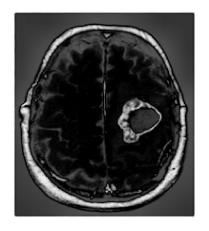

In [149]:
plt.imshow(img_mclahe, cmap='gray')
plt.axis('off')
plt.show()

In [150]:
# print(img_mclahe.shape)
# print(img_original_cv.shape)

In [151]:
import math
import numpy as np
from math import log2
from skimage.metrics import structural_similarity as ssim

class Quantitation:
  # Absolute Mean Brightness Error
  def AMBE(self, image_input, image_output):
    return abs(np.mean(image_input) - np.mean(image_output))

  # Mean Square Error
  def MSE(self, image_input, image_output):
    # err = np.sum((image_input.astype("float") - image_output.astype("float")) ** 2)
    # err /= float(image_input.shape[0] * image_input.shape[1])
    # return err
    err = 10 * math.log10((255 * 255)/cv2.PSNR(image_input, image_output))
    return err

  # Peak Signal to Noise Ratio
  def PSNR(self, image_input, image_output):
    # return 10 * math.log10((255 * 255) / MSE(image_input, image_output))
    return cv2.PSNR(image_input, image_output)
  
  def SNR(self, image_input, image_output):
    ibg = 0
    signal = ((image_input + image_output) / 2 - ibg).sum()
    f = (0.5 ** 0.5) * ((2 / np.pi) ** -0.5)
    noise = np.abs(image_input - image_output).sum() * f
    snr = signal / noise
    return snr

  def SSIM(self, image_input, image_output):
    # return ssim(image_input, image_output, win_size=1, use_sample_covariance=False)
    return ssim(image_input, image_output,multichannel=True)

In [152]:
import numpy as np
from skimage.color import rgb2gray
from skimage.exposure import histogram
import math
def calculate_entropy(image):
  # Convert the image to grayscale
  image = rgb2gray(image)

  # Calculate the histogram of the image
  hist, _ = histogram(image)

  # Normalize the histogram
  hist = hist / hist.sum()

  # Calculate the entropy of the image
  entropy = -sum(p * math.log(p) for p in hist if p != 0)
  
  return entropy

In [153]:
import math
import cv2
import numpy as np
from skimage.exposure import histogram
q = Quantitation()
img3 = img[..., 0] 
img_output = img_mclahe
print(q.MSE(img3,img_output))
print(q.PSNR(img3,img_output))
print(q.AMBE(img3,img_output))
print(q.SNR(img3,img_output))
print(q.SSIM(img3,img_output))
print(calculate_entropy(img_output))

29.60958556675079
71.14130117838786
0.0484023347672784
6.505224521122015
0.7494826466024895
4.121038836503063


<ipython-input-152-2c85a181c7f2>:7: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  image = rgb2gray(image)


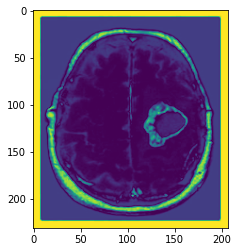

In [154]:
plt.imshow(img[..., 0])

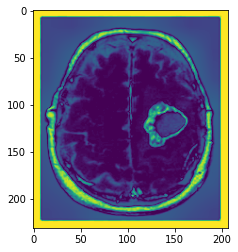

In [155]:
plt.imshow(img_mclahe)

In [156]:
img.dtype

dtype('float64')

In [157]:
img_mclahe.dtype

dtype('float64')

In [158]:
# pip install --upgrade https://github.com/VincentStimper/mclahe/archive/numpy.zip